In [1]:
# qc_mtv_cu_thq_hhtp_qiskit.py
#
# QC-MTV-like Hamiltonian for a toy Cu-THQ-HHTP unit cell
# using Qiskit 1.x+ WITHOUT importing `Sampler` from qiskit.primitives.

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import to_ising

from qiskit.circuit.library import TwoLocal
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import SPSA


def build_cu_thq_hhtp_problem():
    """
    Build a QC-MTV-style QuadraticProgram for a toy Cu-THQ-HHTP system:
      - 8 sites
      - 2 linker types (THQ, HHTP)
      - target composition: 4 THQ, 4 HHTP
      - 8-site ring topology for the 'balance' term
    """
    num_sites = 8
    linkers = ["THQ", "HHTP"]

    target_counts = {"THQ": 4, "HHTP": 4}
    linker_lengths = {"THQ": 5.0, "HHTP": 8.0}

    # Ring topology over 8 sites
    edges = [(i, (i + 1) % num_sites) for i in range(num_sites)]
    weights = {e: 1.0 for e in edges}

    # Ideal average edge length for 50/50 mixture
    L_bar = linker_lengths["THQ"] + linker_lengths["HHTP"]

    qp = QuadraticProgram("Cu_THQ_HHTP_MTV")

    # Binary vars x_{i,t}: linker t at site i
    var_names = {}
    for i in range(num_sites):
        for t in linkers:
            name = f"x_{i}_{t}"
            qp.binary_var(name)
            var_names[(i, t)] = name

    # Occupancy constraints: exactly 1 linker per site
    for i in range(num_sites):
        qp.linear_constraint(
            linear={var_names[(i, t)]: 1.0 for t in linkers},
            sense="==",
            rhs=1.0,
            name=f"occ_{i}",
        )

    # Composition constraints: 4 THQ, 4 HHTP
    for t in linkers:
        qp.linear_constraint(
            linear={var_names[(i, t)]: 1.0 for i in range(num_sites)},
            sense="==",
            rhs=target_counts[t],
            name=f"ratio_{t}",
        )

    # Balance term in the objective: sum (L_edge - L_bar)^2
    quadratic = {}

    for (i, j) in edges:
        for t1 in linkers:
            for t2 in linkers:
                L_edge = linker_lengths[t1] + linker_lengths[t2]
                coeff = (L_edge - L_bar) ** 2

                v1 = var_names[(i, t1)]
                v2 = var_names[(j, t2)]
                key = (v1, v2)
                quadratic[key] = quadratic.get(key, 0.0) + coeff

    qp.minimize(quadratic=quadratic)

    return qp, {
        "num_sites": num_sites,
        "linkers": linkers,
        "edges": edges,
    }


def run_vqe():
    qp, meta = build_cu_thq_hhtp_problem()

    # Convert constrained QP → QUBO
    to_qubo = QuadraticProgramToQubo()
    qubo = to_qubo.convert(qp)

    # QUBO → Ising
    op, offset = to_ising(qubo)

    num_qubits = op.num_qubits

    # Simple ansatz; you can increase reps if you want more expressivity
    ansatz = TwoLocal(
        num_qubits,
        rotation_blocks="ry",
        entanglement_blocks="cz",
        entanglement="linear",
        reps=1,
    )

    # IMPORTANT: avoid deprecated Sampler; use StatevectorSampler instead
    sampler = StatevectorSampler(seed=1234)
    optimizer = SPSA(maxiter=200)

    vqe = SamplingVQE(
        sampler=sampler,
        ansatz=ansatz,
        optimizer=optimizer,
    )

    result = vqe.compute_minimum_eigenvalue(op)

    return result, offset, qubo, meta


def decode_solution(result, offset, qubo, meta):
    """
    Decode the most probable bitstring into a THQ/HHTP assignment.
    """
    num_sites = meta["num_sites"]
    linkers = meta["linkers"]

    # SamplingVQE eigenstate: dict {bitstring -> probability}
    dist = result.eigenstate
    best_bitstring, best_prob = max(dist.items(), key=lambda kv: kv[1])

    # Qiskit orders bits from left (qubit n-1) to right (qubit 0)
    bits = best_bitstring[::-1]

    assignment = {}
    idx = 0
    for i in range(num_sites):
        for t in linkers:
            if bits[idx] == "1":
                assignment[i] = t
            idx += 1

    print("Approx. minimum cost:", result.eigenvalue.real + offset)
    print("Best bitstring:", best_bitstring, f"(p = {best_prob:.3f})")
    print("Decoded linker assignment (site -> linker):")
    for i in range(num_sites):
        print(f"  site {i}: {assignment.get(i, 'None')}")


if __name__ == "__main__":
    result, offset, qubo, meta = run_vqe()
    decode_solution(result, offset, qubo, meta)


/var/folders/4n/x9n_6c9x73bggg4pc3n0y16w0000gn/T/ipykernel_81219/1097177803.py:101: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(


Approx. minimum cost: 378.34765625
Best bitstring: 0101101010100110 (p = 0.276)
Decoded linker assignment (site -> linker):
  site 0: HHTP
  site 1: THQ
  site 2: HHTP
  site 3: HHTP
  site 4: HHTP
  site 5: HHTP
  site 6: THQ
  site 7: THQ


Minimum cost: 0.0
Best configurations (first few): [(0, 1, 0, 1, 0, 1, 0, 1), (1, 0, 1, 0, 1, 0, 1, 0)]


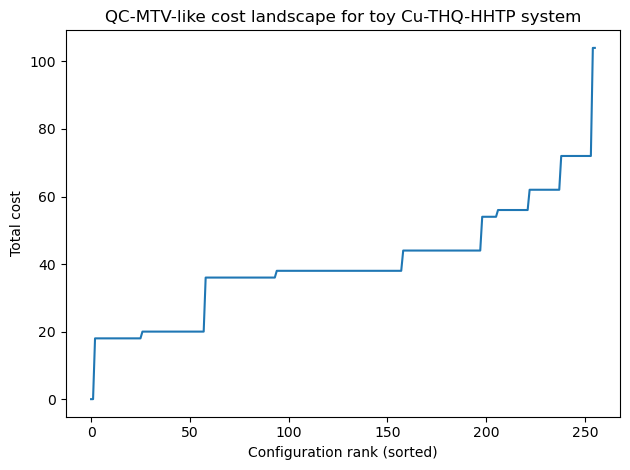

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

N = 8
linker_labels = {0: "THQ", 1: "HHTP"}
L = {"THQ": 5.0, "HHTP": 8.0}

target_THQ = 4
target_HHTP = 4

edges = [(i, (i + 1) % N) for i in range(N)]
w_ij = {e: 1.0 for e in edges}

L_bar = L["THQ"] + L["HHTP"]

def cost_for_config(cfg_bits):
    n_HHTP = sum(cfg_bits)
    n_THQ = N - n_HHTP
    cost_ratio = (n_THQ - target_THQ) ** 2 + (n_HHTP - target_HHTP) ** 2

    cost_balance = 0.0
    for (i, j) in edges:
        Li = L[linker_labels[cfg_bits[i]]]
        Lj = L[linker_labels[cfg_bits[j]]]
        L_edge = Li + Lj
        cost_balance += (L_edge - L_bar) ** 2

    return cost_ratio + cost_balance

configs = list(itertools.product([0, 1], repeat=N))
costs = np.array([cost_for_config(cfg) for cfg in configs])

min_cost = costs.min()
best_indices = np.where(costs == min_cost)[0]
best_configs = [configs[i] for i in best_indices]

print("Minimum cost:", min_cost)
print("Best configurations (first few):", best_configs[:3])

sorted_costs = np.sort(costs)
plt.figure()
plt.plot(sorted_costs)
plt.xlabel("Configuration rank (sorted)")
plt.ylabel("Total cost")
plt.title("QC-MTV-like cost landscape for toy Cu-THQ-HHTP system")
plt.tight_layout()
plt.show()
